# Supervised Machine Learning for Perovskite Thin-Film in-situ Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
import matplotlib.colors as colors
from sklearn.neighbors import KNeighborsRegressor
from torchmetrics import MeanAbsoluteError, MeanSquaredError
import torch

In [2]:
# read in data 
pathData_train = 'data/training_extracted_features_and_labels.h5'
db_train = pd.read_hdf(pathData_train, 'df')
pathData_test = 'data/test_extracted_features_and_labels.h5'
db_test = pd.read_hdf(pathData_test, 'df')

In [3]:
# define plotting parameters
fontSizeSetLarge=18
fontSizeSetMedium=14

In [4]:
# choose channel to use as model input for prediction
useChannel="LP725"
#useChannel="LP780"
#useChannel="SP775"
#useChannel="ND"
#useChannel="plPeak"


# k-nearest neighbors (kNN) regressor

used label:  pce_mean
used channel:  LP725
------------------------------
cross-validation on training set:
determined k: 14
dummy mean regressor:: 1.8967  MAE (absolute)
k-nearest neigbor: 1.5408  MAE (absolute)
delta: -18.76 % (relative)
------------------------------
predictions on test set:
dummy mean regressor: 1.9354  MAE (absolute)
k-nearest neigbor: 1.5156  MAE (absolute)
delta: -21.69 % (relative)
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
used label:  voc_mean
used channel:  LP725
------------------------------
cross-validation on training set:
determined k: 24
dummy mean regressor:: 0.0308  MAE (absolute)
k-nearest neigbor: 0.0282  MAE (absolute)
delta: -8.44 % (relative)
------------------------------
predictions on test set:
dummy mean regressor: 0.0357  MAE (absolute)
k-nearest neigbor: 0.0296  MAE (absolute)
delta: -17.09 % (relative)
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

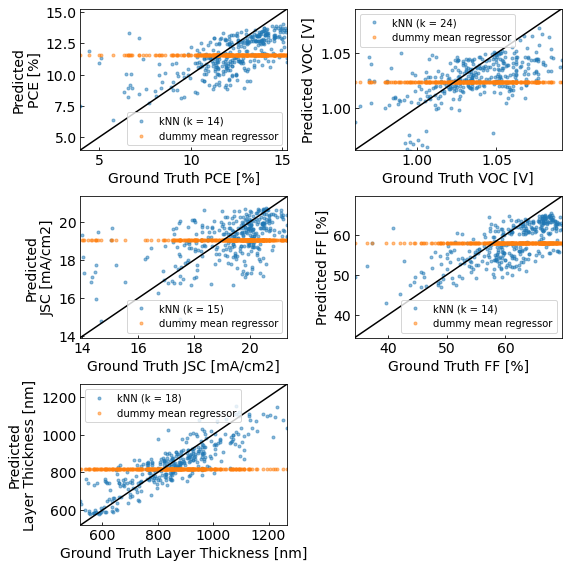

In [5]:
labelsForFigure=["PCE [%]", "VOC [V]", "JSC [mA/cm2]", "FF [%]", "Layer Thickness [nm]"]
list_of_labels=["pce_mean", "voc_mean", "jsc_mean", "ff_mean", "meanThickness"]

fig, axs = plt.subplots(3, 2, figsize=(8,8))
for ix,useLabel in enumerate(list_of_labels):
    print("used label: ",useLabel)
    print("used channel: ",useChannel)
    
    
    # determining hyper parameter by using 5-fold cross-validation on the training set 
    mae_all_folds_knn=[]
    mae_all_folds_dummy=[]
        
    for foldNumber in range(5):
        # get current fold as validation set and remaining 4 folds as training set
        trainset=db_train[db_train["foldNo"]!=foldNumber].copy()
        validset=db_train[db_train["foldNo"]==foldNumber].copy()
        
        # get used channel as input feature and get used label  
        x_train=pd.DataFrame(data=np.vstack(trainset[useChannel].to_numpy()))
        y_train=trainset[useLabel]
        x_valid=pd.DataFrame(data=np.vstack(validset[useChannel].to_numpy()))
        y_valid=validset[useLabel]
        
        # apply kNN for different number of k and add MAE of prediction on validation set to list
        mae_knn_current_fold_diff_ks=[]
        for k in np.arange(1, 30):
            knn = KNeighborsRegressor(k,weights='uniform')
            knn.fit(x_train, y_train)
            predictions = knn.predict(x_valid)
            mae = MeanAbsoluteError()        
            mae_knn_current_fold_diff_ks.append(mae(torch.from_numpy(predictions), torch.from_numpy(np.array(y_valid))))

        # compute mean absolute error (MAE) on current validation set using dummy regressor 
        mae_dummy_current_fold=mae(torch.from_numpy(np.array([y_train.mean()]*len(y_valid))), torch.from_numpy(np.array(y_valid)))
        # append mean absolute error (MAE) of current fold to a list containing values for all folds
        mae_all_folds_knn.append(mae_knn_current_fold_diff_ks)
        mae_all_folds_dummy.append(mae_dummy_current_fold)
  

    # index of minimum mean absolute error (MAE) when using kNN (averaged over all 5 folds)
    indMin=np.argmin(np.mean(np.array(mae_all_folds_knn),axis=0))
    
    print("---"*10)
    print("cross-validation on training set:")
    print("determined k:", indMin+1)
    print("dummy mean regressor::",round(np.mean(mae_all_folds_dummy),4)," MAE (absolute)")
    print("k-nearest neigbor:",round(np.mean(np.array(mae_all_folds_knn),axis=0)[indMin],4)," MAE (absolute)")
    print("delta:",round((round(np.mean(np.array(mae_all_folds_knn),axis=0)[indMin],4)/round(np.mean(mae_all_folds_dummy),4)-1)*100,2),"% (relative)")
    print("---"*10)
    
    #############################################
    # applying model to unseen data in the test set
    
       
    # get used channel as input feature and get used label  
    # use entire training set and all samples in the test set
    x_train=pd.DataFrame(data=np.vstack(db_train[useChannel].to_numpy()))
    y_train=db_train[useLabel]
    x_test=pd.DataFrame(data=np.vstack(db_test[useChannel].to_numpy()))
    y_test=db_test[useLabel]
    
    # index starts at 0, therefore number of used neighbors k equals index of minimum MAE + 1
    k_test=indMin+1
    # predict all samples in the test set
    knn = KNeighborsRegressor(k_test)
    knn.fit(x_train, y_train)
    predictions = knn.predict(x_test)
    
    # calculate mean absolute error (MAE) of test set predictions using kNN and dummy regressor
    mae = MeanAbsoluteError()        
    mae_knn_test=mae(torch.from_numpy(predictions), torch.from_numpy(np.array(y_test)))
    mae_dummy_test=mae(torch.from_numpy(np.array([y_train.mean()]*len(y_test))), torch.from_numpy(np.array(y_test)))

    print("predictions on test set:")
    print("dummy mean regressor:",round(mae_dummy_test.item(),4)," MAE (absolute)")
    print("k-nearest neigbor:",round(mae_knn_test.item(),4)," MAE (absolute)")
    print("delta:",round((round(mae_knn_test.item(),4)/round(mae_dummy_test.item(),4)-1)*100,2),"% (relative)")
    print("xxx"*20)
    print("xxx"*20)
      
    # plot prediction results against ground truth values for all labels as scatter plots    
    ax = axs.flat[ix]
    ax.plot(y_test,predictions, ".", alpha=0.5, label="kNN (k = " + str(k_test)+")")
    ax.plot(y_test,np.array([y_train.mean()]*len(y_test)), ".", alpha=0.5, label="dummy mean regressor")
    minAx=np.min([np.percentile(predictions,2),np.percentile(y_test,2)])
    maxAx=np.max([np.percentile(predictions,98),np.percentile(y_test,98)])
    ax.axline([minAx, minAx], [maxAx, maxAx], color="k")
    ax.set_xlim(minAx,maxAx)
    ax.set_ylim(minAx,maxAx)
    ax.set_xlabel("Ground Truth "+labelsForFigure[ix],fontsize=fontSizeSetMedium)
    if ix%2==0:
        ax.set_ylabel("Predicted\n"+labelsForFigure[ix],fontsize=fontSizeSetMedium)
    else:
        ax.set_ylabel("Predicted "+labelsForFigure[ix],fontsize=fontSizeSetMedium)
    ax.tick_params(axis='both', which='major',direction="in", labelsize=fontSizeSetMedium)
    ax.legend()    
    
    
## access each axes object and check if something was plotted 
for ax in axs.flat:
    if not bool(ax.has_data()):
        fig.delaxes(ax) ## delete if nothing is plotted
fig.tight_layout()
fig.show()